In [1]:
import numpy as np
from scipy import constants as const
from scipy import sparse as sparse
from scipy.sparse.linalg import eigs
from matplotlib import pyplot as plt

from ipywidgets import interact, fixed

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
hbar = 197.3269631
m_n = 938.272013

V0 = -5
r0 = 3

N = 100
l = 0
r = np.linspace(9, 0.0, N, endpoint=False)

In [3]:
def calculate_potential_well(r):
    potential = [ V0 if r[i] < r0 else 0 for i in range(N)]
    potential_term = sparse.diags((potential))
    return potential_term

def calculate_potential_barrier(r):
    potential = [ -V0 if r[i] < r0 else 0 for i in range(N)]
    potential_term = sparse.diags((potential))
    return potential_term

def calculate_potential_coulomb(r):
    potential = [ V0 if r[i] < r0 else -V0 / ( r[i]  - 2.9 ) for i in range(N)]
    potential_term = sparse.diags((potential))
    return potential_term
 
def calculate_angular_term(r):
    angular = l * (l + 1) / r**2
    angular_term = sparse.diags((angular))
    return angular_term
 
def calculate_laplace_three_point(r):
    h = r[1] - r[0]
     
    main_diag = -2.0 / h**2 * np.ones(N)     
    off_diag  =  1.0 / h**2 * np.ones(N - 1)
    laplace_term = sparse.diags([main_diag, off_diag, off_diag], (0, -1, 1))
    return laplace_term
     
def build_hamiltonian_well(r, free=False):
    laplace_term =   calculate_laplace_three_point(r)
    angular_term =   calculate_angular_term(r)
    potential_term = calculate_potential_well(r)
     
    hamiltonian = -hbar**2 / (2.0 * m_n) * (laplace_term - angular_term) + potential_term
 
    return hamiltonian

def build_hamiltonian_barrier(r):
    laplace_term =   calculate_laplace_three_point(r)
    angular_term =   calculate_angular_term(r)
    potential_term = calculate_potential_barrier(r)
     
    hamiltonian = -hbar**2 / (2.0 * m_n) * (laplace_term - angular_term) + potential_term
 
    return hamiltonian

def build_hamiltonian_coulomb(r, free=False):
    laplace_term =   calculate_laplace_three_point(r)
    angular_term =   calculate_angular_term(r)
    potential_term = calculate_potential_coulomb(r)
     
    hamiltonian = -hbar**2 / (2.0 * m_n) * (laplace_term - angular_term) + potential_term
 
    return hamiltonian

def build_hamiltonian_free(r, free=False):
    laplace_term =   calculate_laplace_three_point(r)
     
    hamiltonian = -hbar**2 / (2.0 * m_n) * laplace_term
 
    return hamiltonian

hamiltonian_well = build_hamiltonian_well(r)
hamiltonian_barrier = build_hamiltonian_barrier(r)
hamiltonian_coulomb = build_hamiltonian_coulomb(r)
hamiltonian_free = build_hamiltonian_free(r)

In [4]:
def solve_eigenproblem(hamiltonian):
    """ solve eigenproblem """
    number_of_eigenvalues = 5
    eigenvalues, eigenvectors = eigs(hamiltonian, k=number_of_eigenvalues, which='SM')
 
    """ sort eigenvalue and eigenvectors """
    eigenvectors = np.array([x for _, x in sorted(zip(eigenvalues, eigenvectors.T), key=lambda pair: pair[0])])
    eigenvalues = np.sort(eigenvalues)
 
    """ compute probability density for each eigenvector """
    densities = [np.absolute(eigenvectors[i, :])**2 for i in range(len(eigenvalues))]

    return eigenvalues, densities

In [5]:
def well_shift( E, V0, r0):
    a1 = - np.sqrt( 2 * m_n * E ) / hbar * r0
    a2 = np.arctan( np.sqrt( E / ( V0 + E ) ) * np.tan( np.sqrt( 2 * m_n * ( E + V0 ) ) / hbar * r0 ) )
    return a1 + a2

def well_ratio( E, V0, r0 ):
    return E / ( E + V0 * np.cos( np.sqrt( 2 * m_n * ( E + V0 ) ) / hbar * r0 )**2 )

def plot( Potential=-5, Radius=3 ):
    global V0, r0
    
    V0 = Potential
    r0 = Radius

    hamiltonian_well = build_hamiltonian_well(r)
    hamiltonian_free = build_hamiltonian_free(r)

    eigenvalues, densities = solve_eigenproblem(hamiltonian_well)
    eigenvalues_free, densities_free = solve_eigenproblem(hamiltonian_free)

    # Get indexes from where the eigenvalues are positive
    index = 0

    # Get the eigenvalues and eigenvectors for the positive eigenvalues
    eigenvalues = eigenvalues[index:]
    densities = densities[index:]

    energies = [r'$E_{} = {: >5.1f}$ MeV'.format(i, eigenvalues[i].real) for i in range(0,3)]
    energies_free = [r'$E_{} = {: >5.1f}$ MeV'.format(i, eigenvalues_free[i].real) for i in range(0,3)]

    plt.xlabel('r (fm)')
    plt.ylabel('Probability Density (fm$^{-1}$)')
     
    plt.plot(r, 1000 * densities[0], color='blue',  label=energies[0])
    plt.plot(r, 1000 * densities_free[0], color='blue',  ls="--",  label=energies_free[0])
    
    plt.plot(r, 1000 * densities[1], color='green', label=energies[1])
    plt.plot(r, 1000 * densities_free[1], color='green', ls="--",  label=energies_free[1])

    potential = calculate_potential_well(r).diagonal()
    plt.plot(r, potential, color='black', label='V(r)')

    plt.xlim(0, 9)
     
    plt.show()
    return
 
""" plot results """
interact(plot, Potential=(-20, 20, 1), Radius=(0, 9, 1))

interactive(children=(IntSlider(value=-5, description='Potential', max=20, min=-20), IntSlider(value=3, descri…

<function __main__.plot(Potential=-5, Radius=3)>

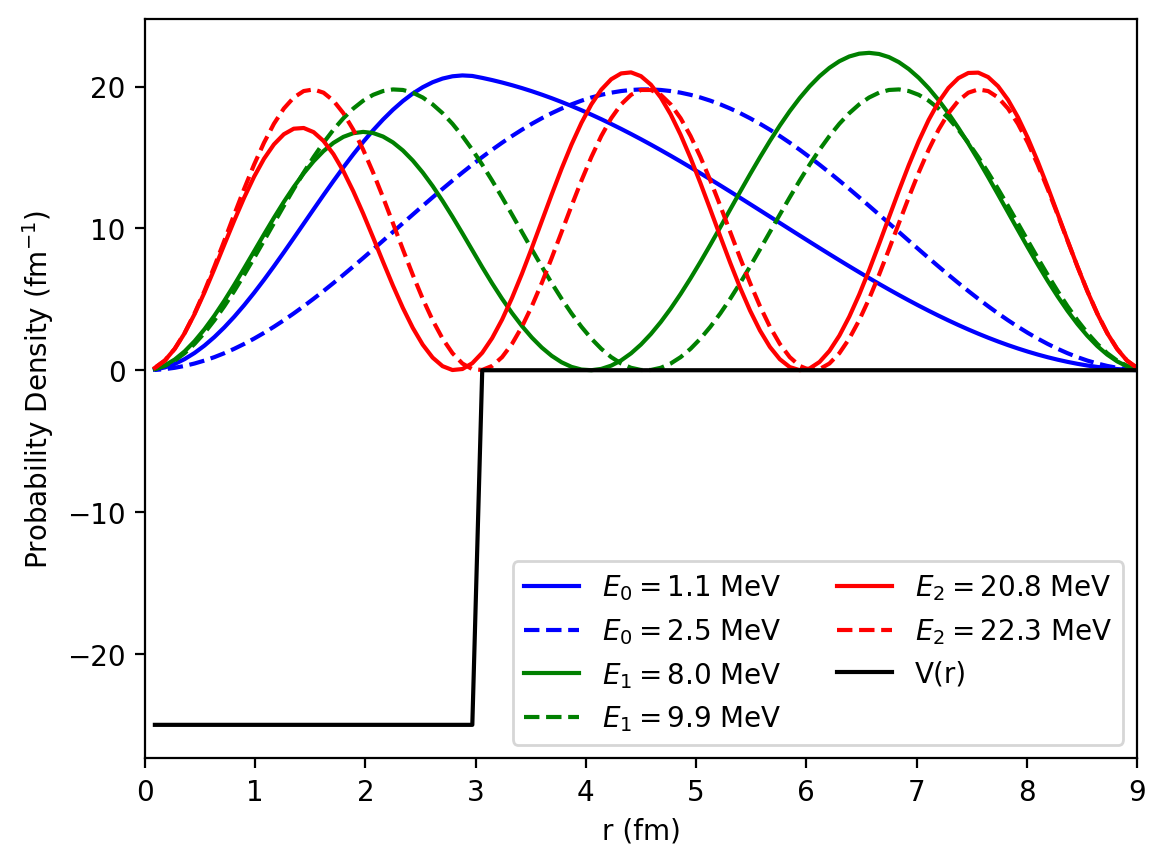

In [6]:
def plot_well( ):

    eigenvalues, densities = solve_eigenproblem(hamiltonian_well)
    eigenvalues_free, densities_free = solve_eigenproblem(hamiltonian_free)

    # Get indexes from where the eigenvalues are positive
    index = np.where(eigenvalues > 0)[0][0]

    # Get the eigenvalues and eigenvectors for the positive eigenvalues
    eigenvalues = eigenvalues[index:]
    densities = densities[index:]

    energies = [r'$E_{} = {: >5.1f}$ MeV'.format(i, eigenvalues[i].real) for i in range(0,3)]
    energies_free = [r'$E_{} = {: >5.1f}$ MeV'.format(i, eigenvalues_free[i].real) for i in range(0,3)]

    plt.xlabel('r (fm)')
    plt.ylabel('Probability Density (fm$^{-1}$)')
     
    plt.plot(r, 1000 * densities[0], color='blue',  label=energies[0])
    plt.plot(r, 1000 * densities_free[0], color='blue',  ls="--",  label=energies_free[0])
    
    plt.plot(r, 1000 * densities[1], color='green', label=energies[1])
    plt.plot(r, 1000 * densities_free[1], color='green', ls="--",  label=energies_free[1])
    
    plt.plot(r, 1000 * densities[2], color='red',   label=energies[2])
    plt.plot(r, 1000 * densities_free[2], color='red',   ls="--",  label=energies_free[2])

    potential = calculate_potential_well(r).diagonal()
    plt.plot(r, potential * 5, color='black', label='V(r)')

    plt.xlim(0, 9)
     
    plt.legend(ncol=2)
    plt.savefig('plots/well_eigen.pdf')
    plt.show()
    return
 
""" plot results """
plot_well( )

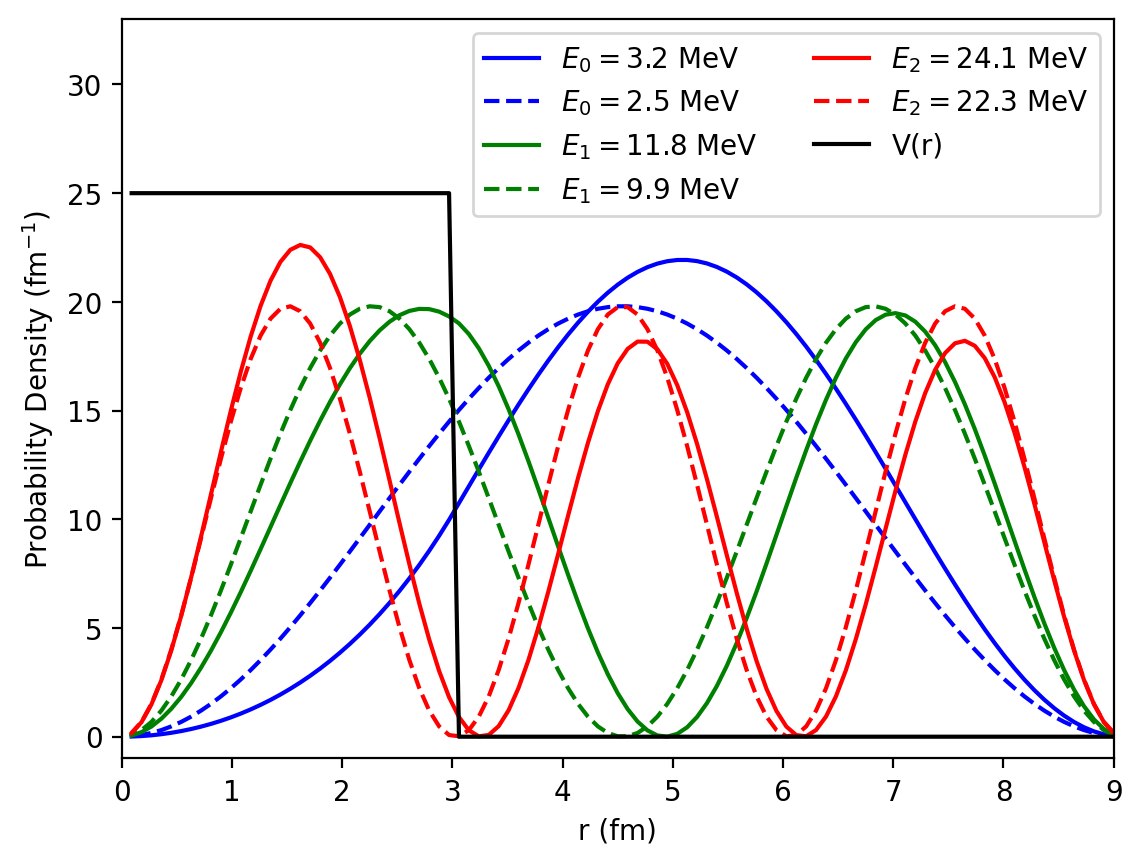

In [7]:
def plot_barrier( ):

    eigenvalues, densities = solve_eigenproblem(hamiltonian_barrier)
    eigenvalues_free, densities_free = solve_eigenproblem(hamiltonian_free)

    # Get indexes from where the eigenvalues are positive
    index = np.where(eigenvalues > 0)[0][0]

    # Get the eigenvalues and eigenvectors for the positive eigenvalues
    eigenvalues = eigenvalues[index:]
    densities = densities[index:]

    energies = [r'$E_{} = {: >5.1f}$ MeV'.format(i, eigenvalues[i].real) for i in range(0,3)]
    energies_free = [r'$E_{} = {: >5.1f}$ MeV'.format(i, eigenvalues_free[i].real) for i in range(0,3)]

    plt.xlabel('r (fm)')
    plt.ylabel('Probability Density (fm$^{-1}$)')
     
    plt.plot(r, 1000 * densities[0], color='blue',  label=energies[0])
    plt.plot(r, 1000 * densities_free[0], color='blue',  ls="--",  label=energies_free[0])
    
    plt.plot(r, 1000 * densities[1], color='green', label=energies[1])
    plt.plot(r, 1000 * densities_free[1], color='green', ls="--",  label=energies_free[1])
    
    plt.plot(r, 1000 * densities[2], color='red',   label=energies[2])
    plt.plot(r, 1000 * densities_free[2], color='red',   ls="--",  label=energies_free[2])

    potential = calculate_potential_barrier(r).diagonal()
    plt.plot(r, potential * 5, color='black', label='V(r)')

    plt.xlim(0, 9)
    plt.ylim( -1, 33 )
     
    plt.legend(ncol=2)
    plt.savefig('plots/barrier_eigen.pdf')
    plt.show()
    return
 
""" plot results """
plot_barrier( )

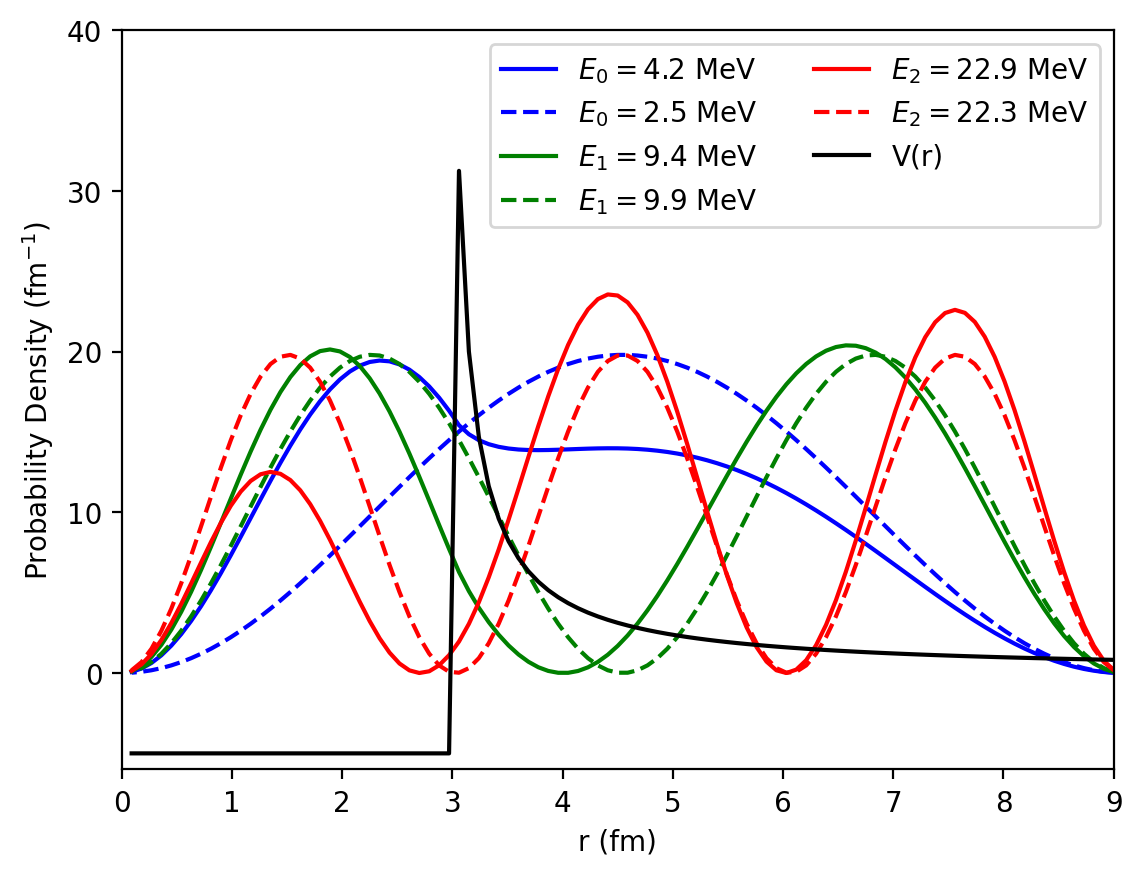

In [8]:
def plot_coulomb( ):

    eigenvalues, densities = solve_eigenproblem(hamiltonian_coulomb)
    eigenvalues_free, densities_free = solve_eigenproblem(hamiltonian_free)

    # Get indexes from where the eigenvalues are positive
    index = np.where(eigenvalues > 0)[0][0]

    # Get the eigenvalues and eigenvectors for the positive eigenvalues
    eigenvalues = eigenvalues[index:]
    densities = densities[index:]

    energies = [r'$E_{} = {: >5.1f}$ MeV'.format(i, eigenvalues[i].real) for i in range(0,3)]
    energies_free = [r'$E_{} = {: >5.1f}$ MeV'.format(i, eigenvalues_free[i].real) for i in range(0,3)]

    plt.xlabel('r (fm)')
    plt.ylabel('Probability Density (fm$^{-1}$)')
     
    plt.plot(r, 1000 * densities[0], color='blue',  label=energies[0])
    plt.plot(r, 1000 * densities_free[0], color='blue',  ls="--",  label=energies_free[0])
    
    plt.plot(r, 1000 * densities[1], color='green', label=energies[1])
    plt.plot(r, 1000 * densities_free[1], color='green', ls="--",  label=energies_free[1])
    
    plt.plot(r, 1000 * densities[2], color='red',   label=energies[2])
    plt.plot(r, 1000 * densities_free[2], color='red',   ls="--",  label=energies_free[2])

    potential = calculate_potential_coulomb(r).diagonal()
    plt.plot(r, potential, color='black', label='V(r)')

    plt.xlim(0, 9)

    plt.ylim( -6, 40 )
     
    plt.legend(ncol=2)
    plt.savefig('plots/coulomb_eigen.pdf')
    plt.show()
    return
 
""" plot results """
plot_coulomb( )